In [1]:
import warnings
warnings.filterwarnings("ignore")
# Libraries to read and manipulate data
import pandas as pd
import numpy as np

# libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from statsmodels.api import OLS, add_constant

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

#libraries for convenience
from datetime import datetime
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data = pd.read_csv('../Resources/Reg_season_games.csv')
# slightly modified version of attendance data
attendence_data = pd.read_csv('../Resources/attendance_marced.csv')
# copying data to preserve original
games_data = data.copy()
attendence_data.drop(['Unnamed: 0'],axis= 1)
attendence_data

,Unnamed: 0,HOME_TEAM_NAME,Year,Attendance
0,0,Pistons,2004,872902
1,1,Mavericks,2004,825594
2,2,Bulls,2004,809177
3,3,76ers,2004,788128
4,4,NY Knicks,2004,785739
...,...,...,...,...
534,554,Magic,2022,622881
535,555,Spurs,2022,615588
536,556,Thunder,2022,595112
537,557,Kings,2022,577583


# Let's see the data:

In [3]:
games_data

,Unnamed: 0,GAME_DATE,HOME_TEAM_ID,HOME_TEAM_NAME,2pointer_PCT_HOME,3pointer_PCT_HOME,FreeThrow_PCT_HOME,Assists_HOME,Rebounds_HOME,VISITOR_TEAM_ID,VISITOR_TEAM_NAME,2pointer_PCT_AWAY,3pointer_PCT_AWAY,FreeThrow_PCT_AWAY,Assists_AWAY,Rebounds_AWAY,HOME_TEAM_WINS
0,17131,2004-04-14,1610612746,Clippers,0.423,0.214,0.727,17.000,37.000,1610612760,Thunder,0.542,0.375,1.000,32.000,34.000,0
1,17132,2004-04-14,1610612759,Spurs,0.424,0.100,0.679,15.000,58.000,1610612743,Nuggets,0.325,0.222,0.611,11.000,47.000,1
2,17133,2004-04-14,1610612754,Pacers,0.420,0.316,0.794,24.000,58.000,1610612741,Bulls,0.420,0.357,0.667,20.000,41.000,1
3,17134,2004-04-14,1610612764,Wizards,0.375,0.211,0.714,13.000,39.000,1610612740,Pelicans,0.451,0.364,0.600,24.000,48.000,0
4,17135,2004-04-14,1610612752,Knicks,0.481,0.400,0.714,13.000,42.000,1610612739,Cavaliers,0.488,0.364,0.900,22.000,40.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21609,2271,2020-12-25,1610612738,Celtics,0.378,0.296,0.684,23.000,47.000,1610612751,Nets,0.539,0.517,0.839,21.000,43.000,0
21610,2272,2020-12-23,1610612754,Pacers,0.489,0.235,0.724,28.000,50.000,1610612752,Knicks,0.459,0.429,0.739,25.000,40.000,1
21611,2273,2020-12-23,1610612755,76ers,0.471,0.286,0.767,22.000,47.000,1610612764,Wizards,0.459,0.481,0.696,28.000,40.000,1
21612,2274,2020-12-23,1610612741,Bulls,0.414,0.229,0.857,20.000,37.000,1610612737,Hawks,0.538,0.400,0.828,24.000,46.000,0


In [4]:
# lets get rid of some of these variables that can't be predicted
games_data = games_data.drop(['Unnamed: 0','HOME_TEAM_ID'],axis=1)

In [5]:
# convert date to datetime datatype for better formatting.
games_data['GAME_DATE'] = pd.to_datetime(games_data['GAME_DATE'],yearfirst=True)

In [6]:
games_data.dtypes

GAME_DATE             datetime64[ns]
HOME_TEAM_NAME                object
2pointer_PCT_HOME            float64
3pointer_PCT_HOME            float64
FreeThrow_PCT_HOME           float64
Assists_HOME                 float64
Rebounds_HOME                float64
VISITOR_TEAM_ID                int64
VISITOR_TEAM_NAME             object
2pointer_PCT_AWAY            float64
3pointer_PCT_AWAY            float64
FreeThrow_PCT_AWAY           float64
Assists_AWAY                 float64
Rebounds_AWAY                float64
HOME_TEAM_WINS                 int64
dtype: object

In [7]:
#games_data['GAME_DATE'] = pd.DatetimeIndex(games_data['GAME_DATE']).year

In [8]:
games_data

,GAME_DATE,HOME_TEAM_NAME,2pointer_PCT_HOME,3pointer_PCT_HOME,FreeThrow_PCT_HOME,Assists_HOME,Rebounds_HOME,VISITOR_TEAM_ID,VISITOR_TEAM_NAME,2pointer_PCT_AWAY,3pointer_PCT_AWAY,FreeThrow_PCT_AWAY,Assists_AWAY,Rebounds_AWAY,HOME_TEAM_WINS
0,2004-04-14,Clippers,0.423,0.214,0.727,17.000,37.000,1610612760,Thunder,0.542,0.375,1.000,32.000,34.000,0
1,2004-04-14,Spurs,0.424,0.100,0.679,15.000,58.000,1610612743,Nuggets,0.325,0.222,0.611,11.000,47.000,1
2,2004-04-14,Pacers,0.420,0.316,0.794,24.000,58.000,1610612741,Bulls,0.420,0.357,0.667,20.000,41.000,1
3,2004-04-14,Wizards,0.375,0.211,0.714,13.000,39.000,1610612740,Pelicans,0.451,0.364,0.600,24.000,48.000,0
4,2004-04-14,Knicks,0.481,0.400,0.714,13.000,42.000,1610612739,Cavaliers,0.488,0.364,0.900,22.000,40.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21609,2020-12-25,Celtics,0.378,0.296,0.684,23.000,47.000,1610612751,Nets,0.539,0.517,0.839,21.000,43.000,0
21610,2020-12-23,Pacers,0.489,0.235,0.724,28.000,50.000,1610612752,Knicks,0.459,0.429,0.739,25.000,40.000,1
21611,2020-12-23,76ers,0.471,0.286,0.767,22.000,47.000,1610612764,Wizards,0.459,0.481,0.696,28.000,40.000,1
21612,2020-12-23,Bulls,0.414,0.229,0.857,20.000,37.000,1610612737,Hawks,0.538,0.400,0.828,24.000,46.000,0


In [9]:
# array for year looping from 2004 to 2021
yearray = np.arange(2004,2022,1)
# lazy code writing via for loop
# for year in yearray:
#     print(f'season_{year} = games_data.loc[(games_data[] == {year})]')
# print('searray = [')
# for year in yearray:
#     print(f'season_{year},')
# print(']')

In [10]:
# using loc by seasons within the range of which season start and end.
season_2004 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2004-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2005-07-01','%Y-%m-%d'))]
season_2005 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2005-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2006-07-01','%Y-%m-%d'))]
season_2006 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2006-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2007-07-01','%Y-%m-%d'))]
season_2007 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2007-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2008-07-01','%Y-%m-%d'))]
season_2008 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2008-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2009-07-01','%Y-%m-%d'))]
season_2009 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2009-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2010-07-01','%Y-%m-%d'))]
season_2010 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2010-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2011-07-01','%Y-%m-%d'))]
season_2011 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2011-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2012-07-01','%Y-%m-%d'))]
season_2012 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2012-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2013-07-01','%Y-%m-%d'))]
season_2013 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2013-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2014-07-01','%Y-%m-%d'))]
season_2014 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2014-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2015-07-01','%Y-%m-%d'))]
season_2015 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2015-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2016-07-01','%Y-%m-%d'))]
season_2016 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2016-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2017-07-01','%Y-%m-%d'))]
season_2017 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2017-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2018-07-01','%Y-%m-%d'))]
season_2018 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2018-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2019-07-01','%Y-%m-%d'))]
season_2019 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2019-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2020-07-01','%Y-%m-%d'))]
season_2020 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2020-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2021-07-01','%Y-%m-%d'))]
season_2021 = games_data.loc[(games_data['GAME_DATE'] > datetime.strptime('2021-08-01','%Y-%m-%d')) & (games_data['GAME_DATE'] < datetime.strptime('2022-07-01','%Y-%m-%d'))]

In [11]:
# array of seasons breakdown dataframes.
searray = [season_2004,season_2005,season_2006,
    season_2007,season_2008,season_2009,season_2010,
    season_2011,season_2012,season_2013,season_2014,
    season_2015,season_2016,season_2017,season_2018,
    season_2019,season_2020,season_2021,]

## Format the data:
- The data needs to be organized to create a breakdown of seasons by means. so instead of individual games, we can use averages
- To do this we will use a function that we can use in a loop to make the dataframes quickly rather than doing it per season.
- The reason why I broke down the data into seasons is because of groupby not handling years very well.

In [12]:
def season_maker(df,year):
    # dataframe of home games stats
    season_home = df[['HOME_TEAM_NAME','2pointer_PCT_HOME','3pointer_PCT_HOME','FreeThrow_PCT_HOME','Assists_HOME','Rebounds_HOME']]
    # dataframe of home game wins
    season_home_W = df[['HOME_TEAM_NAME', 'HOME_TEAM_WINS']]
    # get the means of the games using group by to get the teams data for the season
    season_home = season_home.groupby(['HOME_TEAM_NAME']).mean()
    # get the sum of the wins for the season for each teams
    season_home_W = season_home_W.groupby(['HOME_TEAM_NAME']).sum()
    # similar dataframe to the home games, but using the away games
    season_away = df[['VISITOR_TEAM_NAME','2pointer_PCT_AWAY','3pointer_PCT_AWAY','FreeThrow_PCT_AWAY','Assists_AWAY','Rebounds_AWAY']]
    season_away_W = df[['VISITOR_TEAM_NAME', 'HOME_TEAM_WINS']]
    # the process is mostly the same. that being said, inversing home team wins column for away team wins. DRAWS ARE NOT REAL.
    season_away_W['AWAY_TEAM_WINS'] = season_away_W['HOME_TEAM_WINS'].replace(({0: 1, 1: 0}))
    season_away_W = season_away_W.drop(['HOME_TEAM_WINS'],axis=1)
    season_away = season_away.groupby(['VISITOR_TEAM_NAME']).mean()
    season_away_W = season_away_W.groupby(['VISITOR_TEAM_NAME']).sum()
    # merge the dataframes into seasonal data
    season_inprogress = pd.concat([season_home, season_away, season_home_W, season_away_W], axis=1, join='inner')
    season_inprogress['TEAM_NAME'] = season_inprogress.index
    season_inprogress.reset_index(inplace=True,drop=True)
    season_inprogress['2pointer_PCT_AVG'] = (season_inprogress['2pointer_PCT_HOME'] + season_inprogress['2pointer_PCT_AWAY'])/2
    season_inprogress['3pointer_PCT_AVG'] = (season_inprogress['3pointer_PCT_HOME'] + season_inprogress['3pointer_PCT_AWAY'])/2
    season_inprogress['FreeThrow_PCT_AVG'] = (season_inprogress['FreeThrow_PCT_HOME'] + season_inprogress['FreeThrow_PCT_AWAY'])/2
    season_inprogress['Assists_AVG'] = (season_inprogress['Assists_HOME'] + season_inprogress['Assists_AWAY'])/2
    season_inprogress['Rebounds_AVG'] = (season_inprogress['Rebounds_HOME'] + season_inprogress['Rebounds_AWAY'])/2
    season_inprogress['WINS'] = season_inprogress['HOME_TEAM_WINS'] + season_inprogress['AWAY_TEAM_WINS']
    season_cumulative = season_inprogress[['TEAM_NAME','2pointer_PCT_AVG','3pointer_PCT_AVG','FreeThrow_PCT_AVG','Assists_AVG','Rebounds_AVG','WINS']]
    # adding year which is basically season, but I didn't want to use like 2015-2016 season in case I have to do numerical shenanigans.
    season_cumulative['Year'] = year
    return season_cumulative
    

In [13]:
# loop through list of dataframe and create a combined frame.
combined_df = pd.DataFrame()
for indx in np.arange(0,len(searray),1):
    searray[indx] = season_maker(searray[indx],yearray[indx])
    combined_df = combined_df.append(searray[indx])
# sample dataframe
searray[10]

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year
0,76ers,0.409,0.315,0.678,20.524,42.854,18,2014
1,Bucks,0.461,0.364,0.753,23.561,42.073,41,2014
2,Bulls,0.443,0.354,0.782,21.720,45.744,50,2014
3,Cavaliers,0.459,0.364,0.745,22.122,42.963,53,2014
4,Celtics,0.444,0.326,0.757,24.500,43.841,40,2014
5,Clippers,0.474,0.372,0.711,24.768,42.622,56,2014
6,Grizzlies,0.459,0.336,0.780,21.671,42.561,55,2014
7,Hawks,0.467,0.380,0.777,25.744,40.561,60,2014
8,Heat,0.457,0.336,0.742,19.829,39.122,37,2014
9,Hornets,0.421,0.313,0.748,20.171,44.061,33,2014


In [14]:
combined_df

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year
0,76ers,0.438,0.351,0.788,20.854,42.012,43,2004
1,Bucks,0.452,0.348,0.768,20.976,41.341,30,2004
2,Bulls,0.435,0.354,0.749,21.256,43.805,47,2004
3,Cavaliers,0.448,0.326,0.751,22.573,42.305,42,2004
4,Celtics,0.470,0.347,0.760,22.073,40.817,45,2004
...,...,...,...,...,...,...,...,...
25,Thunder,0.439,0.339,0.724,21.979,45.535,26,2020
26,Timberwolves,0.448,0.350,0.762,25.568,43.527,25,2020
27,Trail Blazers,0.456,0.388,0.823,21.450,44.450,48,2020
28,Warriors,0.467,0.373,0.785,27.397,43.111,40,2020


In [15]:
# using the attenddence data now.
attendence_data = attendence_data.drop(['Unnamed: 0'],axis=1)
attendence_data = attendence_data.loc[(attendence_data['Year'] <= 2020)]
attendence_data

,HOME_TEAM_NAME,Year,Attendance
0,Pistons,2004,872902
1,Mavericks,2004,825594
2,Bulls,2004,809177
3,76ers,2004,788128
4,NY Knicks,2004,785739
...,...,...,...
504,Grizzlies,2020,523297
505,Suns,2020,550633
506,Pistons,2020,509463
507,Hornets,2020,478591


In [16]:
# filling in a missing data entry with an average, to avoid having to drop an entire season or an entire team.
# sorting the dataframes by team name and year to align indexes.
attendence_data.sort_values(by=['HOME_TEAM_NAME','Year'], inplace=True, ascending=True)
attendence_data.HOME_TEAM_NAME.value_counts()
#filling missing attendance number with a mean average.
new_row = {'HOME_TEAM_NAME':'Hornets', 'Year':2004, 'Attendance':634968}
#append row to the dataframe
attendence_data = attendence_data.append(new_row, ignore_index=True)
attendence_data.sort_values(by=['HOME_TEAM_NAME','Year'], inplace=True, ascending=True)
attendence_data.reset_index(inplace=True,drop=True)
print(attendence_data.to_string())

    HOME_TEAM_NAME  Year  Attendance
0            76ers  2004      788128
1            76ers  2005      732686
2            76ers  2006      677278
3            76ers  2007      608603
4            76ers  2008      609675
5            76ers  2009      647898
6            76ers  2010      583219
7            76ers  2011      604823
8            76ers  2012      577597
9            76ers  2013      685412
10           76ers  2014      568632
11           76ers  2015      571572
12           76ers  2016      610121
13           76ers  2017      710557
14           76ers  2018      833503
15           76ers  2019      838092
16           76ers  2020      639491
17           Bucks  2004      690180
18           Bucks  2005      637009
19           Bucks  2006      681337
20           Bucks  2007      663629
21           Bucks  2008      639421
22           Bucks  2009      630976
23           Bucks  2010      619453
24           Bucks  2011      631910
25           Bucks  2012      485717
2

In [17]:
# doing the same thing for the combined dataframe.
combined_df.sort_values(by=['TEAM_NAME','Year'], inplace=True, ascending=True)
combined_df.reset_index(inplace=True,drop=True)
print(combined_df.to_string())
combined_df.TEAM_NAME.value_counts()

         TEAM_NAME  2pointer_PCT_AVG  3pointer_PCT_AVG  FreeThrow_PCT_AVG  Assists_AVG  Rebounds_AVG  WINS  Year
0            76ers             0.438             0.351              0.788       20.854        42.012    43  2004
1            76ers             0.460             0.360              0.756       20.159        40.220    38  2005
2            76ers             0.459             0.350              0.767       20.354        39.659    35  2006
3            76ers             0.460             0.323              0.701       20.402        41.915    40  2007
4            76ers             0.461             0.313              0.743       20.085        41.159    41  2008
5            76ers             0.462             0.341              0.750       21.012        41.000    27  2009
6            76ers             0.463             0.352              0.773       22.695        41.805    41  2010
7            76ers             0.449             0.353              0.742       22.015        43

76ers            17
Bucks            17
Warriors         17
Trail Blazers    17
Timberwolves     17
Thunder          17
Suns             17
Spurs            17
Rockets          17
Raptors          17
Pistons          17
Pelicans         17
Pacers           17
Nuggets          17
Nets             17
Mavericks        17
Magic            17
Lakers           17
Knicks           17
Kings            17
Jazz             17
Hornets          17
Heat             17
Hawks            17
Grizzlies        17
Clippers         17
Celtics          17
Cavaliers        17
Bulls            17
Wizards          17
Name: TEAM_NAME, dtype: int64

In [18]:
combined_df.TEAM_NAME.value_counts()

76ers            17
Bucks            17
Warriors         17
Trail Blazers    17
Timberwolves     17
Thunder          17
Suns             17
Spurs            17
Rockets          17
Raptors          17
Pistons          17
Pelicans         17
Pacers           17
Nuggets          17
Nets             17
Mavericks        17
Magic            17
Lakers           17
Knicks           17
Kings            17
Jazz             17
Hornets          17
Heat             17
Hawks            17
Grizzlies        17
Clippers         17
Celtics          17
Cavaliers        17
Bulls            17
Wizards          17
Name: TEAM_NAME, dtype: int64

In [19]:
attendence_data.HOME_TEAM_NAME.value_counts()

76ers            17
Bucks            17
Warriors         17
Trail Blazers    17
Timberwolves     17
Thunder          17
Suns             17
Spurs            17
Rockets          17
Raptors          17
Pistons          17
Pelicans         17
Pacers           17
Nuggets          17
Nets             17
NY Knicks        17
Mavericks        17
Magic            17
Lakers           17
Kings            17
Jazz             17
Hornets          17
Heat             17
Hawks            17
Grizzlies        17
Clippers         17
Celtics          17
Cavaliers        17
Bulls            17
Wizards          17
Name: HOME_TEAM_NAME, dtype: int64

In [20]:
combined_df['Attendance'] = attendence_data['Attendance']

In [21]:
combined_df

,TEAM_NAME,2pointer_PCT_AVG,3pointer_PCT_AVG,FreeThrow_PCT_AVG,Assists_AVG,Rebounds_AVG,WINS,Year,Attendance
0,76ers,0.438,0.351,0.788,20.854,42.012,43,2004,788128
1,76ers,0.460,0.360,0.756,20.159,40.220,38,2005,732686
2,76ers,0.459,0.350,0.767,20.354,39.659,35,2006,677278
3,76ers,0.460,0.323,0.701,20.402,41.915,40,2007,608603
4,76ers,0.461,0.313,0.743,20.085,41.159,41,2008,609675
...,...,...,...,...,...,...,...,...,...
505,Wizards,0.476,0.374,0.787,23.854,42.854,49,2016,725426
506,Wizards,0.468,0.373,0.776,25.229,43.040,43,2017,697107
507,Wizards,0.468,0.339,0.765,26.268,42.354,32,2018,718946
508,Wizards,0.462,0.372,0.782,25.328,41.688,24,2019,716996


In [22]:
# getting the numbers to be more alike one another.
combined_df['2pointer_PCT_AVG'] = combined_df['2pointer_PCT_AVG'] * 100
combined_df['3pointer_PCT_AVG'] = combined_df['3pointer_PCT_AVG'] * 100
combined_df['FreeThrow_PCT_AVG'] = combined_df['FreeThrow_PCT_AVG'] * 100
combined_df['Attendance'] = combined_df['Attendance'] / 1000

In [23]:
# making a csv file of the sorted one for futher use.
combined_df.to_csv('../Resources/Reg_season_consolidated.csv')  

In [24]:
X = combined_df.drop(['Year','TEAM_NAME','WINS'],axis=1)
y = combined_df['WINS']

<AxesSubplot:>

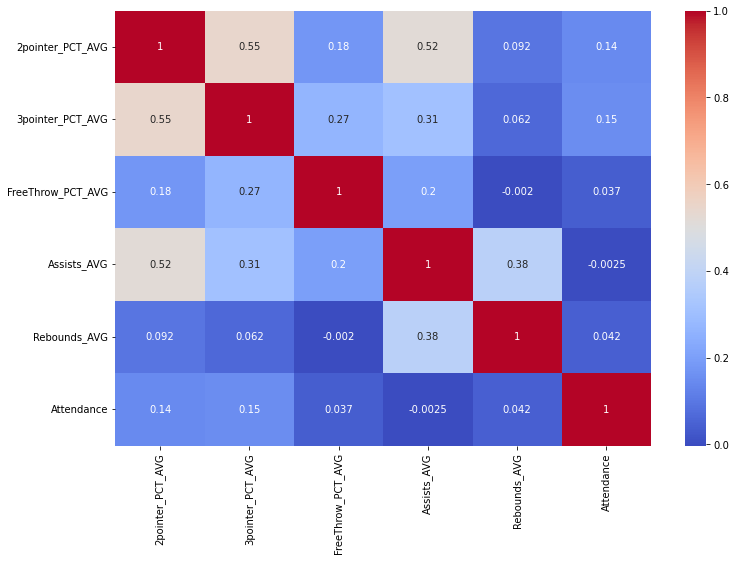

In [25]:
# make a heatmap of the features.
numv = X.columns
corr = X[numv].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True,cmap = 'coolwarm')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [27]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [28]:
for idx, col_name in enumerate(X_train.columns):
    print(f"The coefficient for {col_name} is {regression_model.coef_[idx]}")
intercept = regression_model.intercept_
print(f"The intercept for our model is {intercept}")
rsquare = regression_model.score(X_train, y_train)
rsquare_test = regression_model.score(X_test, y_test)
print(f"The R^2 for our model is {rsquare}")
print(f"The test R^2 for our model is {rsquare_test}")

The coefficient for 2pointer_PCT_AVG is 4.03725676920806
The coefficient for 3pointer_PCT_AVG is 1.420238807015512
The coefficient for FreeThrow_PCT_AVG is 0.08295258002974819
The coefficient for Assists_AVG is -1.0165254697564785
The coefficient for Rebounds_AVG is 1.2197059417433345
The coefficient for Attendance is 0.014112908253609181
The intercept for our model is -240.87082133610284
The R^2 for our model is 0.4561562418812003
The test R^2 for our model is 0.5193092891761462


- assist average might be negative due to multicolinearlity.
- at least R^2

In [29]:
# making an OLS model, as an alternative to linear regression, and also it actually has a very nice breakdown.
X = add_constant(X)
OLS_model = OLS(y, X)
results = OLS_model.fit()
OLS_model = OLS_model.fit()

In [30]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     79.08
Date:                Thu, 26 May 2022   Prob (F-statistic):           2.06e-69
Time:                        19:43:16   Log-Likelihood:                -1841.4
No. Observations:                 510   AIC:                             3697.
Df Residuals:                     503   BIC:                             3727.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -260.4777     17.58

In [31]:
# save the models with the pickels.
import pickle
filename = '../Models/Games_OLS.sav'
pickle.dump(OLS_model, open(filename, 'wb'))
filename = '../Models/Games_LinReg.sav'
pickle.dump(regression_model, open(filename, 'wb'))